
<a href="https://colab.research.google.com/github/takzen/ai-engineering-handbook/blob/main/82_Audio_ASR_CTC_Loss.ipynb" target="_parent">
    <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>


# 🗣️ CTC Loss: Jak dopasować Dźwięk do Tekstu?

W rozpoznawaniu mowy (ASR) mamy problem **Niewyrównania (Alignment)**.
Wejście (Audio) jest znacznie dłuższe niż Wyjście (Tekst).

Sieć neuronowa dla każdej milisekundy dźwięku wypluwa literkę.
Efekt surowy: `KKK--ooo---ttt` (gdzie `-` to cisza/przejście).

**Algorytm CTC Decoding:**
1.  **Krok 1 (Argmax):** Wybierz najbardziej prawdopodobny znak w każdej klatce czasu.
2.  **Krok 2 (Collapse):** Zwiń powtarzające się znaki (np. `KK` -> `K`).
3.  **Krok 3 (Blank Removal):** Usuń znak specjalny `<blank>` (`-`).

Dzięki temu `_pp_ii_zza_` zamienia się w `pizza`.
A `_pp_ii_zz_aa` (gdzie `_` rozdziela dwa `z`) też zamienia się w `pizza`.

Zaimplementujemy **Greedy Decoder** dla CTC.

In [1]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

# 1. SŁOWNIK
# Mamy tylko 4 znaki. Indeks 0 to zawsze BLANK (-) w CTC.
vocab = ['-', 'b', 'e', 'r'] 
# Indeksy: 0='-', 1='b', 2='e', 3='r'

print(f"Słownik: {vocab}")
print("Cel: Zdekodować słowo 'beer' z zaszumionego ciągu.")

Słownik: ['-', 'b', 'e', 'r']
Cel: Zdekodować słowo 'beer' z zaszumionego ciągu.


## Symulacja Wyjścia Sieci (Logity)

Wyobraźmy sobie, że nasza sieć neuronowa (RNN) przetworzyła 10 klatek audio.
Dla każdej klatki zwróciła prawdopodobieństwa dla 4 znaków `[-, b, e, r]`.

Stworzymy macierz prawdopodobieństw ręcznie, żeby symulowała ciąg:
`b` -> `b` -> `-` -> `e` -> `e` -> `e` -> `-` -> `r` -> `r` -> `-`

--- NOWA MACIERZ (Z przerwą między 'e') ---


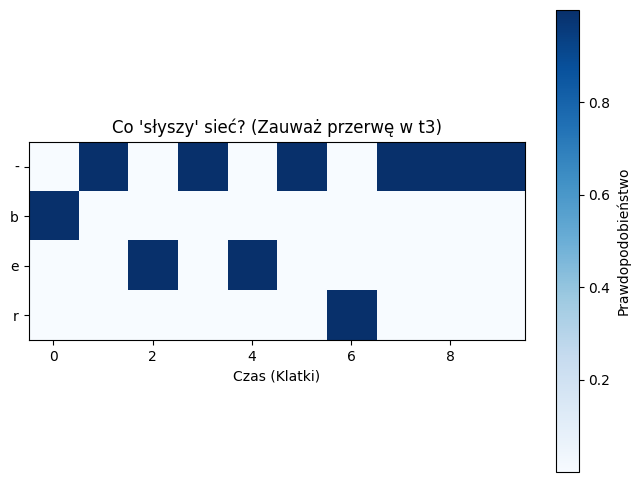

In [5]:
# Czas = 10 kroków, Klasy = 4
# Tworzymy macierz logitów tak, żeby rozdzielić 'e'
# Sekwencja: b -> - -> e -> - -> e -> - -> r -> - ...

logits = torch.tensor([
    # -    b    e    r
    [-5., 10., -5., -5.],  # t0: 'b'
    [10., -5., -5., -5.],  # t1: '-' (Cisza po b)
    [-5., -5., 10., -5.],  # t2: 'e' (Pierwsze e)
    [10., -5., -5., -5.],  # t3: '-' (WAŻNE! Rozdziela dwa e)
    [-5., -5., 10., -5.],  # t4: 'e' (Drugie e)
    [10., -5., -5., -5.],  # t5: '-'
    [-5., -5., -5., 10.],  # t6: 'r'
    [10., -5., -5., -5.],  # t7: '-'
    [10., -5., -5., -5.],  # t8: '-'
    [10., -5., -5., -5.]   # t9: '-'
])

# Zamiana na prawdopodobieństwa (Softmax)
probs = F.softmax(logits, dim=1)

print("--- NOWA MACIERZ (Z przerwą między 'e') ---")
plt.figure(figsize=(8, 6))
plt.imshow(probs.T, cmap='Blues')
plt.yticks(range(4), vocab)
plt.xlabel("Czas (Klatki)")
plt.title("Co 'słyszy' sieć? (Zauważ przerwę w t3)")
plt.colorbar(label="Prawdopodobieństwo")
plt.show()

## Krok 1: Greedy Decoding (Argmax)

Najprostsza metoda. W każdym kroku czasowym bierzemy ten znak, który ma najwyższy słupek (największe prawdopodobieństwo).
Nie patrzymy na kontekst, po prostu bierzemy zwycięzcę chwili.

In [6]:
# Argmax wzdłuż osi klas (dim=1)
best_indices = torch.argmax(probs, dim=1)

print(f"Indeksy wygrane: {best_indices.tolist()}")

# Zamiana na znaki
raw_string = "".join([vocab[i] for i in best_indices])
print(f"Surowy ciąg: '{raw_string}'")

Indeksy wygrane: [1, 0, 2, 0, 2, 0, 3, 0, 0, 0]
Surowy ciąg: 'b-e-e-r---'


## Krok 2: Logika CTC (Zwijanie)

Teraz musimy zastosować reguły CTC, żeby odzyskać sensowne słowo.

**Reguły:**
1.  Zwiń sąsiadujące duplikaty (`ee` -> `e`).
2.  Usuń znaki `Blank` (`-`).

**Ważne:** Kolejność ma znaczenie! Najpierw zwijamy duplikaty, POTEM usuwamy blanki.
Dlaczego?
Spójrz na słowo "bee" (pszczoła).
Sieć widzi: `b... e... - ... e`.
*   Zwijanie: `b` `e` `-` `e`.
*   Usuwanie blanka: `b` `e` `e`. (Sukces! Mamy dwa 'e').

Gdyby nie było blanka po środku (`b... e... e...`), zwinęlibyśmy to do `be` (jedno 'e').

In [7]:
def ctc_decode(indices, vocabulary):
    decoded = []
    last_idx = -1 # Pamiętamy poprzedni znak
    
    # KROK A: Zwijanie duplikatów (Collapse)
    for idx in indices:
        idx = idx.item()
        if idx != last_idx:
            decoded.append(idx)
            last_idx = idx
            
    print(f"Po zwinięciu duplikatów: {[vocabulary[i] for i in decoded]}")
    
    # KROK B: Usuwanie blanków (Blank Removal)
    # Zakładamy, że Blank ma indeks 0
    final_text = [vocabulary[i] for i in decoded if i != 0]
    
    return "".join(final_text)

result = ctc_decode(best_indices, vocab)

print("-" * 30)
print(f"Oryginał (Surowy): '{raw_string}'")
print(f"Wynik CTC:         '{result}'")

if result == "beer":
    print("✅ SUKCES! Zrozumieliśmy słowo 'beer'.")
else:
    print("❌ Coś poszło nie tak.")

Po zwinięciu duplikatów: ['b', '-', 'e', '-', 'e', '-', 'r', '-']
------------------------------
Oryginał (Surowy): 'b-e-e-r---'
Wynik CTC:         'beer'
✅ SUKCES! Zrozumieliśmy słowo 'beer'.


## 🧠 Podsumowanie: Rola Ciszy

W CTC **Blank (Cisza)** pełni kluczową rolę gramatyczną.
To on pozwala odróżnić "długie e" (w słowie *bEEt*) od "dwóch e" (w słowie *bE-Et*).

**Gdzie to spotkasz?**
*   **DeepSpeech (Mozilla):** Czyste CTC.
*   **Wav2Vec 2.0 / HuBERT:** Używają CTC jako jednej z głowic trenujących.
*   **Whisper (OpenAI):** Działa inaczej (Encoder-Decoder Sequence-to-Sequence), więc nie potrzebuje CTC, bo generuje tekst jak GPT (token po tokenie), ale CTC jest lżejsze i szybsze dla prostych komend.